In [7]:
import asyncio
import random
from agents import Agent, ItemHelpers, Runner, function_tool
from dotenv import load_dotenv
import os
from openai.types.responses import ResponseTextDeltaEvent
load_dotenv()


True

In [8]:
@function_tool
def how_many_jokes() -> int:
    return 1

In [9]:
from pydantic import BaseModel, Field

class Joke(BaseModel):
    setup: str = Field(description="The setup of the joke")
    punchline: str = Field(description="The punchline of the joke")


In [10]:
async def test():
    agent = Agent(
        name="Joker",
        instructions="First call the `how_many_jokes` tool, then tell that many jokes.",
        tools=[how_many_jokes],
        output_type=Joke,
    )

    result = Runner.run_streamed(
        agent,
        input="Hello",
    )
    print("=== Run starting ===")

    async for event in result.stream_events():
        # We'll ignore the raw responses event deltas
        if event.type == "raw_response_event" and isinstance(event.data, ResponseTextDeltaEvent):
            # print("Event delta")
            print(event.data.delta, end="", flush=True)
        # When the agent updates, print that
        elif event.type == "agent_updated_stream_event":
            print(f"Agent updated: {event.new_agent.name}")
            continue
        # When items are generated, print them
        elif event.type == "run_item_stream_event":
            if event.item.type == "tool_call_item":
                print(f"-- Tool called: {event.item.raw_item.name}")
                print(f"-- Tool args: {event.item.raw_item.arguments}")
                print(f"-- Tool kwargs: {event.item}")
                print("-- Tool was called")
            elif event.item.type == "tool_call_output_item":
                print(f"-- Tool output: {event.item.output}")
            elif event.item.type == "message_output_item":
                print(f"-- Message output:\n {ItemHelpers.text_message_output(event.item)}")
                output = ItemHelpers.text_message_output(event.item)
                parse_output = Joke.model_validate_json(output)
                print(f"Joke setup: {parse_output.setup}")
                print(f"Joke punchline: {parse_output.punchline}")
            else:
                pass  # Ignore other event types
        else:
            print(f"Unknown event type: {event.type}")

    print("=== Run complete ===")

In [11]:
output = await test()
print(output)

=== Run starting ===
Agent updated: Joker
Unknown event type: raw_response_event
Unknown event type: raw_response_event
Unknown event type: raw_response_event
Unknown event type: raw_response_event
Unknown event type: raw_response_event
Unknown event type: raw_response_event
Unknown event type: raw_response_event
-- Tool called: how_many_jokes
-- Tool args: {}
-- Tool kwargs: ToolCallItem(agent=Agent(name='Joker', instructions='First call the `how_many_jokes` tool, then tell that many jokes.', handoff_description=None, handoffs=[], model=None, model_settings=ModelSettings(temperature=None, top_p=None, frequency_penalty=None, presence_penalty=None, tool_choice=None, parallel_tool_calls=None, truncation=None, max_tokens=None, reasoning=None, metadata=None, store=None, include_usage=None, extra_query=None, extra_body=None, extra_headers=None), tools=[FunctionTool(name='how_many_jokes', description='', params_json_schema={'properties': {}, 'title': 'how_many_jokes_args', 'type': 'object', 

In [12]:
from textwrap import dedent

HOW_MANY_SEARCHES = 3
prompt = dedent("""
  You are a helpful research assistant. You will be given a task to solve as best you can.
  Given a query, come up with a set of web searches to perform to best answer the query.
  To solve the task, you must plan forward to proceed in a series of steps, in a cycle of 'Thought:', 'Queries:', and 'Observation:' sequences.
  At each step, in the 'Thought:' sequence, you should first explain your reasoning towards the web search.
  Then create a few web searches queries 'Queries' to perform to best answer the query.
  Then 'Observation:' to identify if the web searches would provide the information needed to answer the query.
  Here are a few examples:
  ---
  Task: "Which city has the highest population: Guangzhou or Shanghai?"
  Thought: "I need to get the populations for both cities and compare them."
  Queries: ['What is the population of Guangzhou', 'What is the population of Shanghai' ]
  Observation: These queries are enough to answer the question.
  ---
  Task: "What is the current age of the pope, raised to the power 0.36?"
  Thought: "I need to find the age of the pope"
  Queries: ["How is the current pope", "How old is the current pope"]
  Observation: These queries are enough to answer the question, regarding the math calculation that is outside of my reach.

  Here are the rules you should always follow to solve your task:
  1. Always provide a 'Thought:' sequence, and a 'Queries:', 'Observation'.
  2. Only create the queries that will help with the search, you do not perform the search.
  3. Identify all the probable search queries that are relavant for the user query.
  4. Output {HOW_MANY_SEARCHES} terms to query for.

"""
).format(HOW_MANY_SEARCHES=HOW_MANY_SEARCHES)
print(prompt)



You are a helpful research assistant. You will be given a task to solve as best you can.
Given a query, come up with a set of web searches to perform to best answer the query.
To solve the task, you must plan forward to proceed in a series of steps, in a cycle of 'Thought:', 'Queries:', and 'Observation:' sequences.
At each step, in the 'Thought:' sequence, you should first explain your reasoning towards the web search.
Then create a few web searches queries 'Queries' to perform to best answer the query.
Then 'Observation:' to identify if the web searches would provide the information needed to answer the query.
Here are a few examples:
---
Task: "Which city has the highest population: Guangzhou or Shanghai?"
Thought: "I need to get the populations for both cities and compare them."
Queries: ['What is the population of Guangzhou', 'What is the population of Shanghai' ]
Observation: These queries are enough to answer the question.
---
Task: "What is the current age of the pope, raised 

# Input guardrail

In [13]:
from agents import (
    Runner, 
    trace, 
    gen_trace_id, 
    Agent, 
    ItemHelpers,
    input_guardrail,
    RunContextWrapper,
    GuardrailFunctionOutput,
    InputGuardrailTripwireTriggered,
    TResponseInputItem
)
class MathHomeworkOutput(BaseModel):
    is_math_homework: bool
    reasoning: str

guardrail_agent = Agent( 
    name="Guardrail check",
    instructions="Check if the user is asking you to do their math homework.",
    output_type=MathHomeworkOutput,
)

@input_guardrail
async def math_guardrail(ctx: RunContextWrapper[None], agent: Agent, input: str | list[TResponseInputItem]) -> GuardrailFunctionOutput:
    print(f"context: {input}")
    result = await Runner.run(guardrail_agent, input, context=ctx.context)
    return GuardrailFunctionOutput(output_info=result.final_output, tripwire_triggered=result.final_output.is_math_homework)

In [14]:
async def test():
    agent = Agent(
        name="Joker",
        instructions="First call the `how_many_jokes` tool, then tell that many jokes.",
        tools=[how_many_jokes],
        output_type=Joke,
        input_guardrails=[math_guardrail],
    )
    try: 
        result = Runner.run_streamed(
            agent,
            input="what is the square root of 4, I  need this for  my homework?",
        )
        print("=== Run starting ===")
        
        async for event in result.stream_events():
            # We'll ignore the raw responses event deltas
            if event.type == "raw_response_event" and isinstance(event.data, ResponseTextDeltaEvent):
                # print("Event delta")
                print(event.data.delta, end="", flush=True)
            # When the agent updates, print that
            elif event.type == "agent_updated_stream_event":
                print(f"Agent updated: {event.new_agent.name}")
                continue
            # When items are generated, print them
            elif event.type == "run_item_stream_event":
                if event.item.type == "tool_call_item":
                    print(f"-- Tool called: {event.item.raw_item.name}")
                    print(f"-- Tool args: {event.item.raw_item.arguments}")
                    print(f"-- Tool kwargs: {event.item}")
                    print("-- Tool was called")
                elif event.item.type == "tool_call_output_item":
                    print(f"-- Tool output: {event.item.output}")
                elif event.item.type == "message_output_item":
                    print(f"-- Message output:\n {ItemHelpers.text_message_output(event.item)}")
                    output = ItemHelpers.text_message_output(event.item)
                    parse_output = Joke.model_validate_json(output)
                    print(f"Joke setup: {parse_output.setup}")
                    print(f"Joke punchline: {parse_output.punchline}")
                else:
                    pass  # Ignore other event types
            else:
                print(f"Unknown event type: {event.type}")

        print("=== Run complete ===")
    except InputGuardrailTripwireTriggered as e:
        print("Tripwire triggered")
        print(f"Tripwire triggered: {e.__dict__}")
        print(f"Reasoning: {e.guardrail_result.output.output_info.reasoning}")
    
        return

In [15]:
output = await test()
print(output)

=== Run starting ===
Agent updated: Joker
context: [{'content': 'what is the square root of 4, I  need this for  my homework?', 'role': 'user'}]
Unknown event type: raw_response_event
Unknown event type: raw_response_event
Unknown event type: raw_response_event
Unknown event type: raw_response_event
Unknown event type: raw_response_event
Unknown event type: raw_response_event
Unknown event type: raw_response_event
Unknown event type: raw_response_event
-- Tool called: how_many_jokes
-- Tool args: {}
-- Tool kwargs: ToolCallItem(agent=Agent(name='Joker', instructions='First call the `how_many_jokes` tool, then tell that many jokes.', handoff_description=None, handoffs=[], model=None, model_settings=ModelSettings(temperature=None, top_p=None, frequency_penalty=None, presence_penalty=None, tool_choice=None, parallel_tool_calls=None, truncation=None, max_tokens=None, reasoning=None, metadata=None, store=None, include_usage=None, extra_query=None, extra_body=None, extra_headers=None), tools

# Output guardrail

In [16]:
from agents import (
    Runner, 
    trace, 
    gen_trace_id, 
    Agent, 
    ItemHelpers,
    input_guardrail,
    output_guardrail,
    RunContextWrapper,
    GuardrailFunctionOutput,
    InputGuardrailTripwireTriggered,
    TResponseInputItem,
    OutputGuardrailTripwireTriggered
)
class MessageOutput(BaseModel): 
    response: str

class MathOutput(BaseModel): 
    reasoning: str
    is_math: bool

guardrail_agent = Agent( 
    name="Guardrail check",
    instructions="Check if there is any math in the response.",
    output_type=MathOutput,
)

@output_guardrail
async def math_guardrail(  
    ctx: RunContextWrapper, agent: Agent, output: MessageOutput
) -> GuardrailFunctionOutput:
    result = await Runner.run(guardrail_agent, output.response, context=ctx.context)

    return GuardrailFunctionOutput(
        output_info=result.final_output,
        tripwire_triggered=result.final_output.is_math,
    )

In [17]:
async def test():
    agent = Agent(
        name="Joker",
        instructions="First call the `how_many_jokes` tool, then tell that many jokes.",
        tools=[how_many_jokes],
        output_type=MessageOutput,
        output_guardrails=[math_guardrail],
    )
    try: 
        result = Runner.run_streamed(
            agent,
            input="what is the square root of 4, I  need this for  my homework?",
        )
        print("=== Run starting ===")
        
        async for event in result.stream_events():
            # We'll ignore the raw responses event deltas
            if event.type == "raw_response_event" and isinstance(event.data, ResponseTextDeltaEvent):
                # print("Event delta")
                print(event.data.delta, end="", flush=True)
            # When the agent updates, print that
            elif event.type == "agent_updated_stream_event":
                print(f"Agent updated: {event.new_agent.name}")
                continue
            # When items are generated, print them
            elif event.type == "run_item_stream_event":
                continue
            else:
                print(f"Unknown event type: {event.type}")

        print("=== Run complete ===")
    except OutputGuardrailTripwireTriggered as e:
        print("Tripwire triggered")
        print(f"Tripwire triggered: {e.__dict__}")
        print(f"Reasoning: {e.guardrail_result.output.output_info.reasoning}")
    
        return

In [18]:
output = await test()
print(output)

=== Run starting ===
Agent updated: Joker
Unknown event type: raw_response_event
Unknown event type: raw_response_event
Unknown event type: raw_response_event
Unknown event type: raw_response_event
Unknown event type: raw_response_event
Unknown event type: raw_response_event
Unknown event type: raw_response_event
Unknown event type: raw_response_event
Unknown event type: raw_response_event
Unknown event type: raw_response_event
Unknown event type: raw_response_event
{"response":"The square root of 4 is 2!\n\nHere's a joke for you:\n\nWhy was the math book sad?\nBecause it had too many problems!"}Unknown event type: raw_response_event
Unknown event type: raw_response_event
Unknown event type: raw_response_event
Unknown event type: raw_response_event
Tripwire triggered
Tripwire triggered: {'guardrail_result': OutputGuardrailResult(guardrail=OutputGuardrail(guardrail_function=<function math_guardrail at 0x11d2dc900>, name=None), agent_output=MessageOutput(response="The square root of 4 is

# Handoff with Input Guardrail

In [22]:
from pydantic import BaseModel
from typing import Optional
import json
from agents import Agent, ItemHelpers, Runner, function_tool, input_guardrail, output_guardrail, RunContextWrapper, GuardrailFunctionOutput, InputGuardrailTripwireTriggered, OutputGuardrailTripwireTriggered, TResponseInputItem

class HandoffInfo(BaseModel):
    reason: str
    ticket_id: Optional[str] = None

class HandoffOutput(BaseModel):
    should_handoff: bool
    reasoning: str
    handoff_info: Optional[HandoffInfo] = None

# Create a guardrail agent to check if we need to hand off to a human
handoff_guardrail_agent = Agent(
    name="Handoff Check",
    instructions="Check if the user query requires a human agent to handle. If the query mentions account issues, billing problems, or requests to speak with a human, recommend handoff.",
    output_type=HandoffOutput,
)

@input_guardrail
async def handoff_guardrail(ctx: RunContextWrapper[None], agent: Agent, input: str | list[TResponseInputItem]) -> GuardrailFunctionOutput:
    result = await Runner.run(handoff_guardrail_agent, input, context=ctx.context)
    return GuardrailFunctionOutput(
        output_info=result.final_output, 
        tripwire_triggered=result.final_output.should_handoff
    )
final_agent = Agent(
        name="CustomerSupport",
        instructions="You are a helpful customer support agent. Answer customer queries.",
        tools=[how_many_jokes],
        output_type=MessageOutput,
        input_guardrails=[handoff_guardrail],
    )
# Test function to demonstrate handoff behavior
async def test_handoff():
    
    
    try: 
        result = Runner.run_streamed(
            final_agent,
            input="I've been charged twice for my subscription and need to speak to a human agent immediately.",
        )
        print("=== Run starting ===")
        
        async for event in result.stream_events():
            if event.type == "raw_response_event" and isinstance(event.data, ResponseTextDeltaEvent):
                print(event.data.delta, end="", flush=True)
            elif event.type == "agent_updated_stream_event":
                print(f"\nAgent updated: {event.new_agent.name}")
            elif event.type == "run_item_stream_event":
                if event.item.type == "message_output_item":
                    print(f"\nMessage: {ItemHelpers.text_message_output(event.item)}")
                
        print("\n=== Run complete ===")
    except InputGuardrailTripwireTriggered as e:
        print("\nHandoff required!")
        print(f"Reason: {e.guardrail_result.output.output_info.reasoning}")
        if e.guardrail_result.output.output_info.handoff_info:
            print(f"Handoff info: {json.dumps(e.guardrail_result.output.output_info.handoff_info.model_dump(), indent=2)}")
        
        # In a real application, you might create a ticket or route to human support here
        ticket_id = f"TICKET-{random.randint(10000, 99999)}"
        print(f"Created support ticket: {ticket_id}")
        return ticket_id

In [25]:
output = await test_handoff()
print(output)

=== Run starting ===

Agent updated: CustomerSupport
{"response":"I understand your concern regarding the double charge on your subscription, and I'm here to assist you. To speak directly with a human agent who can help resolve this issue, please provide your contact details or
Handoff required!
Reason: The user is facing a billing problem and explicitly requests to speak with a human agent.
Handoff info: {
  "reason": "Billing issue: Charged twice for subscription.",
  "ticket_id": null
}
Created support ticket: TICKET-83166
TICKET-83166


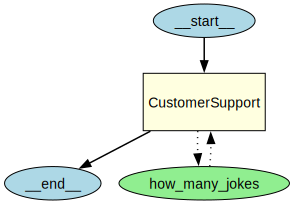

In [24]:
from agents.extensions.visualization import draw_graph
draw_graph(final_agent)

In [27]:
from __future__ import annotations

import asyncio
import json

from pydantic import BaseModel, Field

from agents import (
    Agent,
    GuardrailFunctionOutput,
    OutputGuardrailTripwireTriggered,
    RunContextWrapper,
    Runner,
    output_guardrail,
)

"""
This example shows how to use output guardrails.

Output guardrails are checks that run on the final output of an agent.
They can be used to do things like:
- Check if the output contains sensitive data
- Check if the output is a valid response to the user's message

In this example, we'll use a (contrived) example where we check if the agent's response contains
a phone number.
"""


# The agent's output type
class MessageOutput(BaseModel):
    reasoning: str = Field(description="Thoughts on how to respond to the user's message")
    response: str = Field(description="The response to the user's message")
    user_name: str | None = Field(description="The name of the user who sent the message, if known")


@output_guardrail
async def sensitive_data_check(context: RunContextWrapper, agent: Agent, output: MessageOutput) -> GuardrailFunctionOutput:
    phone_number_in_response = "650" in output.response
    phone_number_in_reasoning = "650" in output.reasoning

    return GuardrailFunctionOutput(
        output_info={
            "phone_number_in_response": phone_number_in_response,
            "phone_number_in_reasoning": phone_number_in_reasoning,
        },
        tripwire_triggered=phone_number_in_response or phone_number_in_reasoning,
    )


agent = Agent(
    name="Assistant",
    instructions="You are a helpful assistant.",
    output_type=MessageOutput,
    output_guardrails=[sensitive_data_check],
)


async def event_123():
    # This should be ok
    await Runner.run(agent, "What's the capital of California?")
    print("First message passed")

    # This should trip the guardrail
    try:
        result = await Runner.run(
            agent, "My phone number is 650-123-4567. Where do you think I live?"
        )
        print(
            f"Guardrail didn't trip - this is unexpected. Output: {json.dumps(result.final_output.model_dump(), indent=2)}"
        )

    except OutputGuardrailTripwireTriggered as e:
        print(f"Guardrail tripped. Info: {e.guardrail_result.output.output_info}")




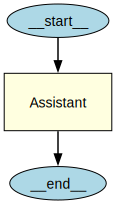

In [28]:
draw_graph(agent)

In [29]:
output = await event_123()
print(output)

First message passed
Guardrail tripped. Info: {'phone_number_in_response': True, 'phone_number_in_reasoning': True}
None
